## Import libraries

In [ ]:
import sys
import os
sys.path.append(os.path.abspath("..")) # 

from tqdm import tqdm

from PIL import Image

import matplotlib.pyplot as plt

import torch
from torch import Tensor
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from src.models.resnet import ResNet

### Relative path of data

In [2]:
train_data_path = r'..\\dataset\\train'
test_data_path = r'..\\dataset\\test'

### Display one sample of image

(300, 300)


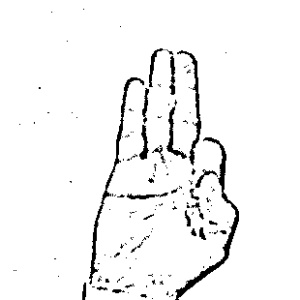

In [3]:
image = Image.open(os.path.join(train_data_path, 'F\\10.jpg'))
print(image.size)
image

## Total labels
Including `0` when there is no hand in box and alphabets `A-Z`

In [4]:
labels = os.listdir(train_data_path)
numeric_labels = {label: idx for idx, label in enumerate(labels)}
reverse_numeric_labels = {idx: label for label, idx in numeric_labels.items()}
print(numeric_labels)
print(reverse_numeric_labels)

{'0': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}
{0: '0', 1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z'}


# Load Data

Loading train and test dataset using `ImageFolder` from `pytorch datasets` module

__Imagefolder__: A generic data loader where the images are arranged in this way by default:
                 `folder/class1/(images files)`, `folder/class2/(images files)`

## Transforms

1. __Resize__: Resizes images that are 300x300 to 128x128 for better computation

2. __Grayscale__: Since our images have processed during the data creation and for hand gestures hand shape and edges matter more than color we consider grayscale for images and move from 3 channels images to 1 channel

3. __ToTensor__: Transforms images from PIL images to pytorch tensors

4. __Normalize__: It makes training more stable by standardizing the data distribution and if some images are brighter/darker, normalization reduces their impact and also if images have varying intensity ranges, normalization ensures they follow a similar distribution.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), # (3, 300, 300) -> (3, 128, 128)
    transforms.Grayscale(num_output_channels=1), # (3, 128, 128) -> grayscale and (1, 128, 128)
    transforms.ToTensor(), # transform from PIL to Tensor
    transforms.Normalize(mean=[0.947], std=[0.177]) # (Image - mean) / std
])

train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [6]:
batch_images, batch_labels = next(iter(train_dataloader))
print(f'training data shape: images -> {batch_images.shape}, labels -> {batch_labels.shape}')

training data shape: images -> torch.Size([64, 1, 128, 128]), labels -> torch.Size([64])


set device to move tensors and model to GPU for faster computation

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Define model

In this section, we define the ResNet model architecture and initialize the optimizer and loss function.

- **Model Definition**: We use a custom ResNet model with the following layers:
    - Convolutional layers and Residual blocks with ReLU activation and Batch Normalization.
    - MaxPooling layers to reduce the spatial dimensions.
    - Fully connected layers with Dropout for regularization.

- **Optimizer**: We use the AdamW optimizer with a learning rate of 0.0001 and weight decay of 1e-4.

- **Loss Function**: We use CrossEntropyLoss, which is suitable for multi-class classification tasks.

The model is moved to the GPU (if available) for faster computation.

In [8]:
model = ResNet(in_channels=1).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [12]:
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res1): ResBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res2): ResBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_

## Training and Evaluating phase of model

Training model on 7 epochs and saving the `train losses`, `test losses` and `test accuracies` for each epoch

In [ ]:
train_losses = []
test_losses = []
test_accuracies = []

epochs = 7

for epoch in tqdm(range(epochs)):
    # Training phase
    model.train()
    epoch_loss = 0
    num_train_batches = len(train_dataloader)

    for i, (img, label) in enumerate(train_dataloader):
        img, label = img.to(device), label.to(device) # Move images to device

        logits = model(img) # Predict logits (Batch size, 27)
        loss: Tensor = loss_fn(logits, label) # Calculate loss

        # Update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / num_train_batches
    train_losses.append(avg_train_loss)

    # Test phase (eval phase)
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    num_test_batches = len(test_dataloader)

    with torch.no_grad():
        for img, label in test_dataloader:
            img, label = img.to(device), label.to(device) # Move images to device

            logits = model(img) # Predict logits (Batch size, 27)
            loss: Tensor = loss_fn(logits, label) # Calculate loss
            test_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(logits, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)

    avg_test_loss = test_loss / num_test_batches
    test_accuracy = correct / total * 100
    test_losses.append(avg_test_loss)
    
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{epochs} - Avg Train Loss: {avg_train_loss:.4f}')
    print(f'Epoch {epoch+1}/{epochs} - Avg Test Loss: {avg_test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

 14%|█▍        | 1/7 [07:41<46:06, 461.07s/it]

Epoch 1/7 - Avg Train Loss: 1.5413
Epoch 1/7 - Avg Test Loss: 0.3241, Accuracy: 91.91%


 29%|██▊       | 2/7 [10:39<24:33, 294.70s/it]

Epoch 2/7 - Avg Train Loss: 0.1499
Epoch 2/7 - Avg Test Loss: 0.3599, Accuracy: 87.36%


 43%|████▎     | 3/7 [13:31<15:55, 238.91s/it]

Epoch 3/7 - Avg Train Loss: 0.0680
Epoch 3/7 - Avg Test Loss: 0.6840, Accuracy: 86.55%


 57%|█████▋    | 4/7 [16:26<10:40, 213.54s/it]

Epoch 4/7 - Avg Train Loss: 0.0384
Epoch 4/7 - Avg Test Loss: 0.1348, Accuracy: 96.94%


 71%|███████▏  | 5/7 [19:20<06:38, 199.22s/it]

Epoch 5/7 - Avg Train Loss: 0.0300
Epoch 5/7 - Avg Test Loss: 0.3949, Accuracy: 93.92%


 86%|████████▌ | 6/7 [22:22<03:13, 193.57s/it]

Epoch 6/7 - Avg Train Loss: 0.0172
Epoch 6/7 - Avg Test Loss: 0.5864, Accuracy: 91.60%


100%|██████████| 7/7 [25:19<00:00, 217.03s/it]

Epoch 7/7 - Avg Train Loss: 0.0164
Epoch 7/7 - Avg Test Loss: 0.1768, Accuracy: 95.18%


Saving the model

In [10]:
torch.save(model.state_dict(), '..\\weights\\asl_model_weights.pth')

### Plot loss and accuracy of the model for each epoch

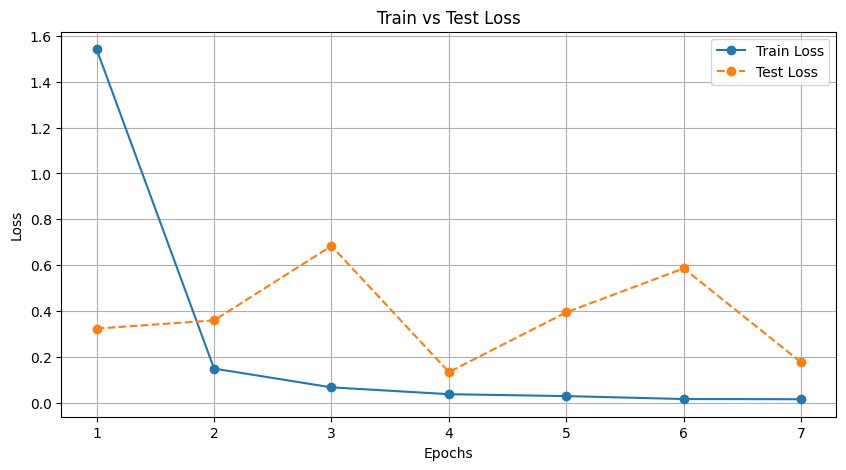

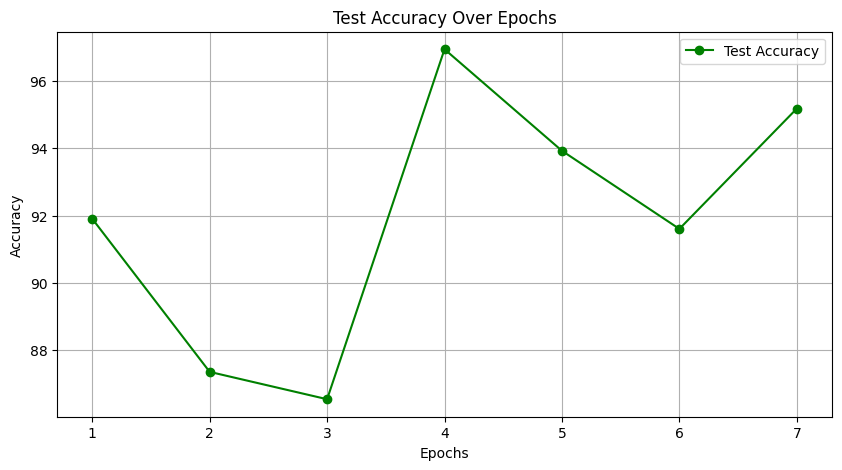

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, epochs+1), test_losses, label="Test Loss", marker="o", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), test_accuracies, label="Test Accuracy", marker="o", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()